# Exploratory Data Analysis - Creating Metrics
This notebook is focused on creating a simple set of metrics for the data at hand.

Naming convention is a number (for ordering), the creator's initials, and a short `-` delimited description. [source](https://cookiecutter-data-science.drivendata.org/)

In [1]:
import os
import json
import numpy as np

In [2]:
!ls ../examples/model_outputs/

2.json	4.json	5.json	7.json


In [3]:
!ls ../examples/ground_truth/

example_01.json  example_05.json  example_09.json  example_13.json
example_02.json  example_06.json  example_10.json
example_03.json  example_07.json  example_11.json
example_04.json  example_08.json  example_12.json


In [4]:
data = {}
for model in os.listdir("../examples/model_outputs/"):
    with open(f"../examples/model_outputs/{model}", 'r') as f:
        data[f'model_{model.split(".json")[0]}'] = json.load(f)

In [5]:
data

{'model_4': {'estimate_preds': [{'valid_file_name': 'example_01',
    'rows': [{'label': 'Protect Work Area and Surroundings',
      'qty': 74.0,
      'uom': 'SF',
      'rateUsd': 0.25,
      'rowTotalCostUsd': 18.5,
      'category': 'labor',
      'sectionName': 'Demolition',
      'metadata': None},
     {'label': 'Demo Floor Tile',
      'qty': 8.0,
      'uom': 'HRS',
      'rateUsd': 65.0,
      'rowTotalCostUsd': 520.0,
      'category': 'labor',
      'sectionName': 'Demolition',
      'metadata': None},
     {'label': 'Demo Tub/Shower Combo',
      'qty': 4.0,
      'uom': 'HRS',
      'rateUsd': 65.0,
      'rowTotalCostUsd': 260.0,
      'category': 'labor',
      'sectionName': 'Demolition',
      'metadata': None},
     {'label': 'Demo Vanity',
      'qty': 2.0,
      'uom': 'HRS',
      'rateUsd': 65.0,
      'rowTotalCostUsd': 130.0,
      'category': 'labor',
      'sectionName': 'Demolition',
      'metadata': None},
     {'label': 'Demo Toilet',
      'qty': 1.0,
  

In [6]:
data.keys()

dict_keys(['model_4', 'model_7', 'model_5', 'model_2'])

In [7]:
gt_data = {}
for fn in os.listdir("../examples/ground_truth/"):
    with open(f"../examples/ground_truth/{fn}", 'r') as f:
        gt_data[fn.split('.json')[0]] = json.load(f)

In [8]:
gt_data.keys()

dict_keys(['example_08', 'example_11', 'example_09', 'example_03', 'example_05', 'example_06', 'example_13', 'example_12', 'example_07', 'example_10', 'example_02', 'example_01', 'example_04'])

In [9]:
list(set([r['category'] for r in data["model_2"]['estimate_preds'][0]['rows']]))

['labor', 'material']

In [10]:
gt_data["example_01"]

{'test_n': 1,
 'input': 'Bathroom Remodel project: 7\'x10\'-6", 8 ft ceilings\nDemo a tub/shower combo\nReplace with a complete shower system, with tiled walls, niche, and curb.\nReplace tile floor with new tile.\nNew double vanity.\nNew Toilet.\nPlumbing fixtures stay in place, no relocation or new rough-in needed.\nRepaint whole room 3 coats.\nReplace 4 light fixtures.\nShower Glass Enclosure excluded.',
 'rows': [{'sectionName': 'Demolition',
   'qty': 66.0,
   'rateUsd': 2.4,
   'rowTotalCostUsd': 158.4,
   'label': 'Demo Shower Surround',
   'uom': 'SF',
   'category': 'other'},
  {'sectionName': 'Demolition',
   'qty': 1.0,
   'rateUsd': 80.0,
   'rowTotalCostUsd': 80.0,
   'label': 'Demo Vanity',
   'uom': 'EA',
   'category': 'other'},
  {'sectionName': 'Demolition',
   'qty': 73.0,
   'rateUsd': 4.0,
   'rowTotalCostUsd': 292.0,
   'label': 'Demo Tile',
   'uom': 'SF',
   'category': 'other'},
  {'sectionName': 'Demolition',
   'qty': 1.0,
   'rateUsd': 240.0,
   'rowTotalCost

NOTE: The ground_truth data only comprises the work estimate and the materials cost is included. Therefore, we could advance to separate these and compare 'labor' and 'material' costs separately.

### Cost Metrics
- Total cost: an important aspect of cost metrics is that the total cost should be close to the expert estimate and should be penalized by how far off it is, but linear penalization might not be the best approach here because of pricing elasticity;
- Per section cost: the evaluation method should be capable of matching the model estimate and expert estimate at a service level and understand if these are comparable.

#### Total Cost Score

The total cost score will be made with a simple MAE, but the caveat of having to fit in a distribuition

In [11]:
gt_total = gt_data["example_01"]['totalCostUsd']
lm_total = sum([r["rowTotalCostUsd"] for r in data["model_2"]["estimate_preds"][0]['rows']])

In [12]:
ELASTICITY = 0.1

In [13]:
lm_total

10227.15

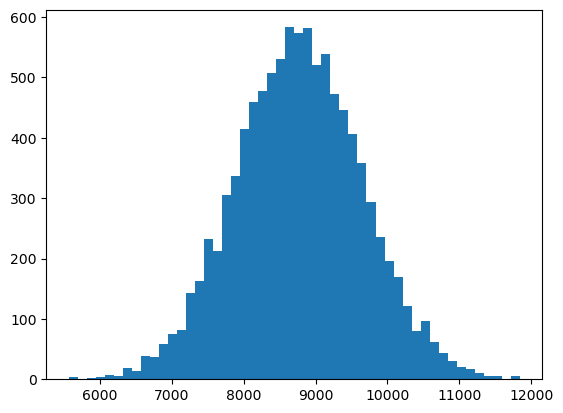

In [14]:
from matplotlib import pyplot as plt
plt.hist(np.random.normal(gt_total, gt_total*ELASTICITY, 10000), 50);

In [15]:
import scipy.stats

In [16]:
def is_model_within_distribuition(estimate, expert_estimate, CONFIDENCE_INTERVAL, ELASTICITY):
    lower, upper = scipy.stats.norm.interval(CONFIDENCE_INTERVAL, expert_estimate, expert_estimate*ELASTICITY)
    return lower <= estimate <= upper

In [17]:
CONFIDENCE_INTERVAL = 0.95
lower, upper = scipy.stats.norm.interval(CONFIDENCE_INTERVAL, gt_total, gt_total*ELASTICITY)

In [18]:
lower, gt_total, upper, lm_total

(7040.498738017965, 8756.8, 10473.101261982034, 10227.15)

In [19]:
is_model_within_distribuition(lm_total, gt_total, CONFIDENCE_INTERVAL, ELASTICITY)

True

For this instance we've got that the model output should be within 7040 USD and 10473 USD. Since it is, the score will be created using MAE, then normalized.

In [20]:
lm_total = sum([r["rowTotalCostUsd"] for r in data['model_7']["estimate_preds"][1]['rows']])
is_model_within_distribuition(lm_total, gt_total, CONFIDENCE_INTERVAL, ELASTICITY)

False

In [21]:
lower, gt_total, upper, lm_total

(7040.498738017965, 8756.8, 10473.101261982034, 1620.0)

Here we get a negative example which will not even be scored because it falls way out of the expected distribuition.

In [22]:
gt_total = gt_data["example_01"]['totalCostUsd']
lm_total = sum([r["rowTotalCostUsd"] for r in data['model_2']["estimate_preds"][1]['rows']])

In [23]:
gt_data['example_01']['rows']

[{'sectionName': 'Demolition',
  'qty': 66.0,
  'rateUsd': 2.4,
  'rowTotalCostUsd': 158.4,
  'label': 'Demo Shower Surround',
  'uom': 'SF',
  'category': 'other'},
 {'sectionName': 'Demolition',
  'qty': 1.0,
  'rateUsd': 80.0,
  'rowTotalCostUsd': 80.0,
  'label': 'Demo Vanity',
  'uom': 'EA',
  'category': 'other'},
 {'sectionName': 'Demolition',
  'qty': 73.0,
  'rateUsd': 4.0,
  'rowTotalCostUsd': 292.0,
  'label': 'Demo Tile',
  'uom': 'SF',
  'category': 'other'},
 {'sectionName': 'Demolition',
  'qty': 1.0,
  'rateUsd': 240.0,
  'rowTotalCostUsd': 240.0,
  'label': 'Demo Tub',
  'uom': 'EA',
  'category': 'other'},
 {'sectionName': 'Demolition',
  'qty': 3.0,
  'rateUsd': 120.0,
  'rowTotalCostUsd': 360.0,
  'label': 'Demo Plumbing Fixtures',
  'uom': 'EA',
  'category': 'other'},
 {'sectionName': 'Demolition',
  'qty': 4.0,
  'rateUsd': 80.0,
  'rowTotalCostUsd': 320.0,
  'label': 'Demo Light Fixtures',
  'uom': 'EA',
  'category': 'other'},
 {'sectionName': 'Demolition',
  '

In [24]:
data['model_7']['estimate_preds'][0]['rows']

[{'label': 'Mask Off and Protect Work Area',
  'qty': 1000.0,
  'uom': 'SF',
  'rateUsd': 0.1,
  'rowTotalCostUsd': 100.0,
  'category': 'material',
  'sectionName': 'Painting',
  'metadata': None},
 {'label': 'Prepare Wall Surfaces for Paint',
  'qty': 2500.0,
  'uom': 'SF',
  'rateUsd': 0.1,
  'rowTotalCostUsd': 250.0,
  'category': 'material',
  'sectionName': 'Painting',
  'metadata': None},
 {'label': 'Prepare Ceiling Surfaces for Paint',
  'qty': 1000.0,
  'uom': 'SF',
  'rateUsd': 0.1,
  'rowTotalCostUsd': 100.0,
  'category': 'material',
  'sectionName': 'Painting',
  'metadata': None},
 {'label': 'Finish Paint Sherwin Williams Contractor Line',
  'qty': 18.0,
  'uom': 'GAL',
  'rateUsd': 35.0,
  'rowTotalCostUsd': 630.0,
  'category': 'material',
  'sectionName': 'Painting',
  'metadata': None},
 {'label': 'Painting Supplies and Consumables',
  'qty': 1.0,
  'uom': 'EA',
  'rateUsd': 50.0,
  'rowTotalCostUsd': 50.0,
  'category': 'ensemble materials',
  'sectionName': 'Paintin

#### Section Score and Section Cost Score
The same approach will be used to define the section cost, but, before going in head first, we need to evaluate if the model is doing a good job at section creation.

In [25]:
sorted(list(set([r['sectionName'] for r in gt_data['example_10']['rows']])))

['Cleaning',
 'Demolition',
 'Drywall',
 'Flooring',
 'Insulation',
 'Moving',
 'Painting',
 'Tile']

In [26]:
for model in sorted(data.keys()):
    print(model)
    print(sorted(list(set([r['sectionName'] for r in data[model]['estimate_preds'][19]['rows']]))))
    print("-----")

model_2
['Cleaning', 'Contents', 'Demolition', 'Drywall', 'Flooring', 'Insulation', 'Painting', 'Tile']
-----
model_4
['Demolition', 'Drywall', 'Labor', 'Painting', 'Plumbing', 'Tile']
-----
model_5
['Appliances', 'Cabinets', 'Countertops', 'Demolition', 'Electrical', 'Flooring', 'Painting', 'Plumbing', 'Tile', 'Trim']
-----
model_7
['Cleaning', 'Concrete', 'Demolition', 'Doors', 'Electrical', 'Framing', 'HVAC', 'Insulation', 'Painting', 'Plumbing', 'Roofing', 'Siding', 'Tile', 'Trim', 'Windows']
-----


Turns out we can do a simple counting of overlapping sections because the model sections and the expert sections are the same

In [27]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.metrics import f1_score
import torch

torch.cuda.empty_cache()
encoder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

def is_similar(encoder, s1, s2, threshold=0.7):
    if s1 == s2:
        return True
        
    return cos_sim(encoder.encode(s1), encoder.encode(s2)) >= threshold

def section_score(encoder, expert_sections: list, model_sections: list):  
    expert_dict = {section: estimate for section, estimate in expert_sections}
    model_dict = {section: estimate for section, estimate in model_sections}

    all_sections = list(set(expert_dict.keys()) | set(model_dict.keys()))
    y_true, y_pred = [], []
    estimate_diffs = []

    matched_expert, matched_model = set(), set()

    for section in all_sections:
        found_expert, found_model = False, False

        for expert_section in expert_dict:
            if is_similar(encoder, section, expert_section):
                y_true.append(1)
                matched_expert.add(expert_section)
                found_expert = True
                break
        if not found_expert:
            y_true.append(0)

        for model_section in model_dict:
            if is_similar(encoder, section, model_section):
                y_pred.append(1)
                matched_model.add(model_section)
                found_model = True
                
                if found_expert:
                    expert_estimate = expert_dict[expert_section]
                    model_estimate = model_dict[model_section]
                    estimate_diffs.append(abs(expert_estimate - model_estimate) / expert_estimate)
                
                break
        if not found_model:
            y_pred.append(0)

    # Compute metrics
    f1 = f1_score(y_true, y_pred)
    mape = np.mean(estimate_diffs) if estimate_diffs else None  # Avoid division by zero

    return f1, mape

/home/rosilva/anaconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2025-02-23 01:39:40.685010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 01:39:40.695040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740285580.706740 2950465 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174028558

In [28]:
data[model]['estimate_preds']

[{'valid_file_name': 'example_03',
  'rows': [{'label': 'Mask Off and Protect Work Area',
    'qty': 1000.0,
    'uom': 'SF',
    'rateUsd': 0.1,
    'rowTotalCostUsd': 100.0,
    'category': 'material',
    'sectionName': 'Painting',
    'metadata': None},
   {'label': 'Prepare Wall Surfaces for Paint',
    'qty': 2500.0,
    'uom': 'SF',
    'rateUsd': 0.1,
    'rowTotalCostUsd': 250.0,
    'category': 'material',
    'sectionName': 'Painting',
    'metadata': None},
   {'label': 'Prepare Ceiling Surfaces for Paint',
    'qty': 1000.0,
    'uom': 'SF',
    'rateUsd': 0.1,
    'rowTotalCostUsd': 100.0,
    'category': 'material',
    'sectionName': 'Painting',
    'metadata': None},
   {'label': 'Finish Paint Sherwin Williams Contractor Line',
    'qty': 18.0,
    'uom': 'GAL',
    'rateUsd': 35.0,
    'rowTotalCostUsd': 630.0,
    'category': 'material',
    'sectionName': 'Painting',
    'metadata': None},
   {'label': 'Painting Supplies and Consumables',
    'qty': 1.0,
    'uom': 

In [29]:
for example in sorted(gt_data):
    print(example)
    for model in sorted(data):
        print(model)
        preds = data[model]['estimate_preds']
        
        for pred in preds:
            if pred['valid_file_name'] != example:
                continue
            
            model_section_estimates = {
                section: sum(r['rowTotalCostUsd'] for r in pred['rows'] if r['sectionName'] == section)
                for section in {r['sectionName'] for r in pred['rows']}
            }
            
            expert_section_estimates = {
                section: sum(r['rowTotalCostUsd'] for r in gt_data[example]['rows'] if r['sectionName'] == section)
                for section in {r['sectionName'] for r in gt_data[example]['rows']}
            }

            f1, mape = section_score(encoder, list(model_section_estimates.items()), list(expert_section_estimates.items()))
            
            print(f"F1: {f1}")
            print(f"MAPE: {mape}")
            print("Model Sections:", model_section_estimates)
            print("GT Sections:   ", expert_section_estimates)
            print("---")
    print("-----")


example_01
model_2
F1: 0.8333333333333334
MAPE: 0.6708767780697643
Model Sections: {'Tile': 3882.0, 'Cabinets': 2160.0, 'Electrical': 1460.0, 'Demolition': 1263.75, 'Painting': 521.4, 'Plumbing': 940.0}
GT Sections:    {'Trim': 144.0, 'Tile': 2704.0, 'Electrical': 960.0, 'Demolition': 1508.0, 'Painting': 1000.8000000000001, 'Plumbing': 2440.0}
---
F1: 0.8333333333333334
MAPE: 1.4197136390552645
Model Sections: {'Tile': 3882.0, 'Cabinets': 1720.0, 'Electrical': 460.0, 'Demolition': 1133.75, 'Painting': 521.4, 'Plumbing': 447.0}
GT Sections:    {'Trim': 144.0, 'Tile': 2704.0, 'Electrical': 960.0, 'Demolition': 1508.0, 'Painting': 1000.8000000000001, 'Plumbing': 2440.0}
---
model_4
F1: 0.8333333333333334
MAPE: 0.3211295421271299
Model Sections: {'Tile': 4651.0, 'Cabinets': 1825.0, 'Electrical': 1400.0, 'Demolition': 1523.5, 'Painting': 583.6, 'Plumbing': 2126.0}
GT Sections:    {'Trim': 144.0, 'Tile': 2704.0, 'Electrical': 960.0, 'Demolition': 1508.0, 'Painting': 1000.8000000000001, 'Plum

Seems like using F1 to compute the section overlap with some help from a sentence encoder really helped the process.